In [94]:
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [95]:
load_dotenv()

True

In [96]:
model = ChatOpenAI(model='gpt-4o-mini')

In [97]:
class SentimentSchema(BaseModel):

    sentiment: Literal['positive', 'negitive'] = Field(description='sentiment of the review')

In [98]:
class diaganoseSchema(BaseModel):
    issue_type: Literal["UX","Performence","Bug","Support","Other"] = Field(description="The catagory of the issue mentioned in the review")
    tone: Literal["angry","frustrated","disappointed","calm"] = Field(description="The emotional tone expressed by user")
    urgency: Literal["low","medium","high"] = Field(description="how urgent or criticl the issue appears to be")

In [99]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(diaganoseSchema)

In [100]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negitive']
    diaganose: str 
    response: str

In [101]:
def find_sentiment(state: ReviewState):
    prompt = f"for the following review find out of the sentiment \n {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

In [102]:
def check_sentiment(state: ReviewState) -> Literal["positive_response","run_daignosis"]:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_daignosis'

def positive_response(state: ReviewState):
    prompt = f""" Write a warm thank-you in respice to this review:
    \n\n"{state['review']}\"\n
    Also, kindly ask the user to leave a feedback to our website.
    """

    response = model.invoke(prompt).content

    return {'response' : response}

def run_daignosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n
Return issue_type, tone, and urgency.
"""

    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}


def negitive_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""

    response = model.invoke(prompt).content

    return {'response': response}

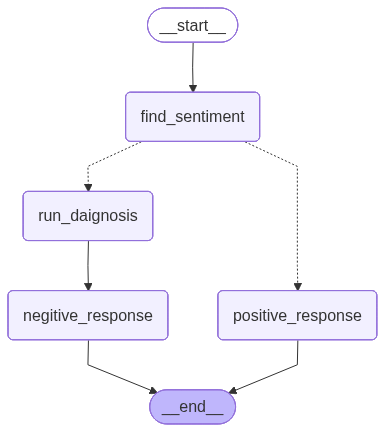

In [115]:
state = StateGraph(ReviewState)

state.add_node('find_sentiment', find_sentiment)
state.add_node('positive_response', positive_response)
state.add_node('run_daignosis', run_daignosis)
state.add_node('negitive_response', negitive_response)

state.add_edge(START, 'find_sentiment')
state.add_conditional_edges('find_sentiment', check_sentiment)
state.add_edge('positive_response', END)
state.add_edge('run_daignosis', "negitive_response")
state.add_edge('find_sentiment', END)


workflow = state.compile()

workflow

In [116]:
initial_state = {
    'review' : "the product was really good"
}

workflow.invoke(initial_state)

{'review': 'the product was really good',
 'sentiment': 'positive',
 'response': "Subject: Thank You for Your Kind Words!\n\nDear [User's Name],\n\nThank you so much for your wonderful review! We’re thrilled to hear that you enjoyed the product. Your satisfaction means the world to us and motivates our team to continue delivering quality.\n\nIf you have a moment, we would greatly appreciate it if you could share your experience on our website. Your feedback helps us improve and assist other customers in making informed choices.\n\nThank you once again for your support!\n\nWarm regards,  \n[Your Name]  \n[Your Position]  \n[Your Company]  "}